## Introduction to Deep Learning 
# Exercise with Keras and solution


In [249]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import utils_plot as uplot
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, log_loss

%matplotlib inline  

## Utilities

In [250]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

def print_stats(ytest, ypred):
    
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [251]:
def drow_history_list(history_list, history_names=None,  metric=None):
    
    if metric is None:
        metric = 'loss'
        
    leg = []
    if history_names is not None:
        for n in history_names:
            leg.append('train ' + n)
            leg.append('test ' + n)
    else:
        for n in range(len(history_list)):
            leg.append('train ' + str(n))
            leg.append('test ' + str(n))
            
    for hist in history_list:
        
        plt.plot(hist.history[metric])
        plt.plot(hist.history['val_'+ metric], '--', linewidth=2)
        
        
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(leg, loc='auto')
    plt.show()  

## Exercise - Parkinson classification

* Can you improve the result ?
* Try different optimizers, Adadelta, Adam
* Try different batch sized.

* My best result was:

Accuracy: 0.73077, Cohen's Kappa Score: 0.46054<br>
Confusion Matrix:<br>
[[107  44]<br>
 [ 40 121]]<br>
Classification Report:<br>
              precision    recall  f1-score   support<br>

           0       0.73      0.71      0.72       151
           1       0.73      0.75      0.74       161


## Lets start Keras
In the Mnist classification example, we saw that the net basically learn templates.<br>
This is not robust enough for generalization. <br>
To generalize, we want the neural network to learn **features**. <br>
For that we will need deeper and more complexed networks.<br>
Lets build our first neural network with Keras.

In [252]:
import keras
# Keras has many build in data sets
from keras.datasets import mnist
# Sequential is the basic feed forward neural network (FFN)
from keras.models import Sequential
# Dense is fully connected layer
# Dropout is a "noising" layer, to prevent over feet.
from keras.layers import Dense, Dropout
# Read about optimizers in keras documentation
from keras.optimizers import RMSprop
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [253]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

## Parkinson binary classification example
### Create, normalize and split data

In [254]:
df = pd.read_csv('parkinsons_updrs.data.txt')
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [255]:
len(df.columns)

22

In [256]:
df = pd.read_csv('parkinson.txt', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1,1.488,0.000090,0.900,0.794,2.699,8.334,0.779,4.517,4.609,...,187.576,160,159,0.006065,0.000416,0.000,0,0.000,23,1
1,1,0.728,0.000038,0.353,0.376,1.059,5.864,0.642,2.058,3.180,...,234.505,170,169,0.005181,0.000403,2.247,0,0.000,23,1
2,1,1.220,0.000074,0.732,0.670,2.196,8.719,0.875,4.347,5.166,...,211.442,1431,1427,0.006071,0.000474,10.656,1,0.178,23,1
3,1,2.502,0.000123,1.156,1.634,3.469,13.513,1.273,5.263,8.771,...,220.230,94,92,0.004910,0.000320,0.000,0,0.000,23,1
4,1,3.509,0.000167,1.715,1.539,5.145,9.112,1.040,3.102,4.927,...,225.162,117,114,0.004757,0.000380,18.182,1,13.318,23,1


In [257]:
X = df[df.columns[1:27]]
y=df[28]

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    random_state=42)

X_train.shape

C:\Users\naomi\Miniconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\naomi\Miniconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(728, 26)

### Build and compile keras model - Adadelta optimizer

In [258]:
np.random.seed(1235)

batch_size = 20
epochs = 30

def get_model(lsize=64, optimizer=RMSprop()):
    model = Sequential()
    model.add(Dense(lsize, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.1))
    model.add(Dense(lsize, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

model=get_model(optimizer=optimizers.Adadelta())
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 64)                1728      
_________________________________________________________________
dropout_77 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_116 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_78 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 65        
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [259]:
checkpoint = ModelCheckpoint('best_model_e40_b20_oAdam.h5', verbose=1, 
                             monitor='val_loss',
                             save_best_only=True, mode='auto') 

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,callbacks=[checkpoint],
                    validation_data=(X_test, y_test))


Train on 728 samples, validate on 312 samples
Epoch 1/30
728/728 [==============================] - 2s 2ms/step - loss: 0.6711 - acc: 0.5755 - val_loss: 0.6477 - val_acc: 0.6474

Epoch 00001: val_loss improved from inf to 0.64771, saving model to best_model_e40_b20_oAdam.h5
Epoch 2/30
728/728 [==============================] - 0s 136us/step - loss: 0.6347 - acc: 0.6264 - val_loss: 0.6363 - val_acc: 0.6571

Epoch 00002: val_loss improved from 0.64771 to 0.63631, saving model to best_model_e40_b20_oAdam.h5
Epoch 3/30
728/728 [==============================] - 0s 160us/step - loss: 0.6161 - acc: 0.6566 - val_loss: 0.6198 - val_acc: 0.6763

Epoch 00003: val_loss improved from 0.63631 to 0.61977, saving model to best_model_e40_b20_oAdam.h5
Epoch 4/30
728/728 [==============================] - 0s 148us/step - loss: 0.6037 - acc: 0.6525 - val_loss: 0.6132 - val_acc: 0.6699

Epoch 00004: val_loss improved from 0.61977 to 0.61316, saving model to best_model_e40_b20_oAdam.h5
Epoch 5/30
728/728 [

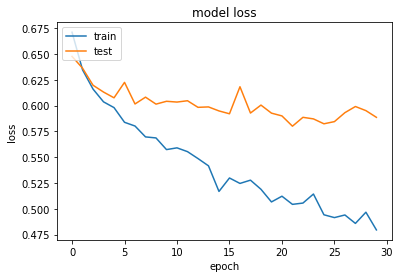

In [260]:
uplot.drow_history(history, 'loss')

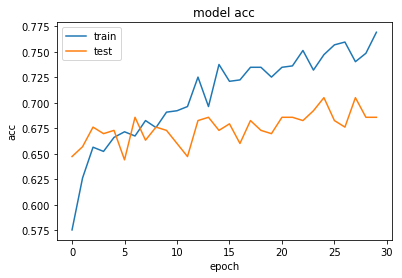

In [261]:
uplot.drow_history(history, 'acc')

In [262]:

model_best = get_model(optimizer=optimizers.Adadelta())
model_best.load_weights('best_model_e40_b20_oAdam.h5')

## Evaluate model

In [263]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.588675142863
Test accuracy: 0.685897437426


In [264]:
score = model_best.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.580090426482
Test accuracy: 0.685897435897


## Predict

In [265]:
pred_test = model.predict(X_test)
y_pred_test = np.where(pred_test > 0.5, 1, 0).flatten()
print_stats(y_test,y_pred_test )

Accuracy: 0.68590, Cohen's Kappa Score: 0.36724
Confusion Matrix:
[[ 87  64]
 [ 34 127]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.58      0.64       151
           1       0.66      0.79      0.72       161

   micro avg       0.69      0.69      0.69       312
   macro avg       0.69      0.68      0.68       312
weighted avg       0.69      0.69      0.68       312



In [266]:
pred_test = model_best.predict(X_test)
y_pred_test = np.where(pred_test > 0.5, 1, 0).flatten()
print_stats(y_test,y_pred_test )

Accuracy: 0.68590, Cohen's Kappa Score: 0.37037
Confusion Matrix:
[[ 99  52]
 [ 46 115]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67       151
           1       0.69      0.71      0.70       161

   micro avg       0.69      0.69      0.69       312
   macro avg       0.69      0.68      0.69       312
weighted avg       0.69      0.69      0.69       312



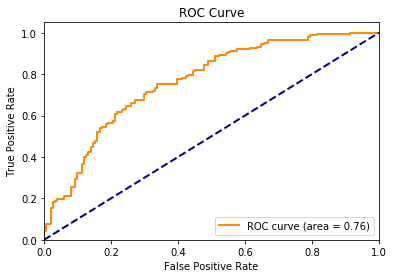

In [267]:
uplot.drow_roc_curve(y_test, model.predict(X_test))

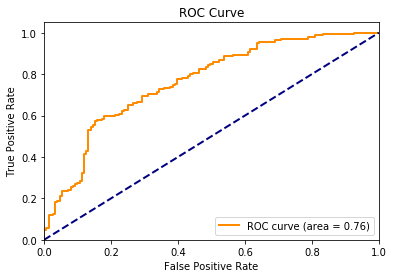

In [268]:
uplot.drow_roc_curve(y_test, model_best.predict(X_test))

In [269]:
pred_test = model_best.predict(X_test)
y_pred_test = np.where(pred_test > 0.625, 1, 0).flatten()
print_stats(y_test,y_pred_test )

Accuracy: 0.69872, Cohen's Kappa Score: 0.40271
Confusion Matrix:
[[128  23]
 [ 71  90]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.85      0.73       151
           1       0.80      0.56      0.66       161

   micro avg       0.70      0.70      0.70       312
   macro avg       0.72      0.70      0.69       312
weighted avg       0.72      0.70      0.69       312




### Adam optimizer.

In [270]:
batch_size = 20
epochs = 10

model = get_model(lsize=64, optimizer=keras.optimizers.Adam(lr=0.01))                  

In [271]:
history_adam = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))


Train on 728 samples, validate on 312 samples
Epoch 1/10
728/728 [==============================] - 2s 2ms/step - loss: 0.6918 - acc: 0.5865 - val_loss: 0.6541 - val_acc: 0.5673
Epoch 2/10
728/728 [==============================] - 0s 153us/step - loss: 0.6333 - acc: 0.6264 - val_loss: 0.6141 - val_acc: 0.6603
Epoch 3/10
728/728 [==============================] - 0s 151us/step - loss: 0.5940 - acc: 0.6662 - val_loss: 0.6250 - val_acc: 0.6571
Epoch 4/10
728/728 [==============================] - 0s 138us/step - loss: 0.5852 - acc: 0.6937 - val_loss: 0.6131 - val_acc: 0.6667
Epoch 5/10
728/728 [==============================] - 0s 147us/step - loss: 0.5744 - acc: 0.6896 - val_loss: 0.6121 - val_acc: 0.6795
Epoch 6/10
728/728 [==============================] - 0s 162us/step - loss: 0.5607 - acc: 0.7184 - val_loss: 0.6050 - val_acc: 0.6763
Epoch 7/10
728/728 [==============================] - 0s 179us/step - loss: 0.5692 - acc: 0.6841 - val_loss: 0.6106 - val_acc: 0.6699
Epoch 8/10
728/728

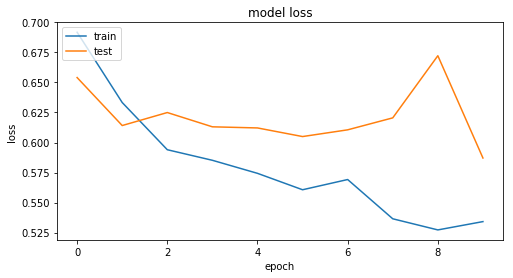

In [272]:
from IPython.core.pylabtools import figsize
figsize(8,4)
uplot.drow_history(history_adam,metric='loss')

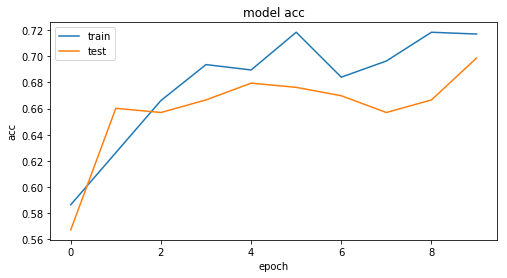

In [273]:
uplot.drow_history(history_adam,metric='acc')

In [274]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.587113488943
Test accuracy: 0.69871794719


## Predict

In [275]:
pred_test = model.predict(X_test)
y_pred_test = np.where(pred_test > 0.5, 1, 0).flatten()
print_stats(y_test,y_pred_test )

Accuracy: 0.69872, Cohen's Kappa Score: 0.39457
Confusion Matrix:
[[ 95  56]
 [ 38 123]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       151
           1       0.69      0.76      0.72       161

   micro avg       0.70      0.70      0.70       312
   macro avg       0.70      0.70      0.70       312
weighted avg       0.70      0.70      0.70       312



In [276]:
pred_test = model.predict(X_test)
pred_test[0:5].flatten()

array([ 0.62952977,  0.22472243,  0.58098429,  0.49335015,  0.51873404], dtype=float32)

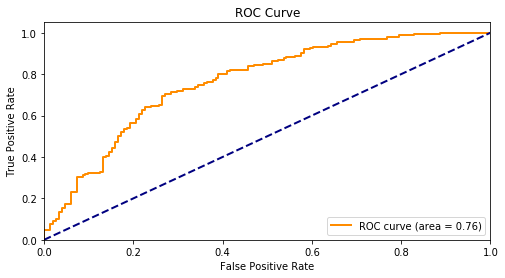

In [277]:
uplot.drow_roc_curve(y_test, pred_test)

### Result, until now SGD is the best optimizer

## Batch size

In [278]:
np.random.seed(1235)


epochs = 30
sgd = optimizers.SGD(lr=0.1)
model = get_model(lsize=64, optimizer=sgd)                  
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model_e50_b20_oSgd.h5', verbose=0, 
                             monitor='val_acc',
                             save_best_only=True, mode='auto') 

history_sgd_b20 = model.fit(X_train, y_train,
                    batch_size=20,
                    epochs=epochs,
                    verbose=0,callbacks=[checkpoint],
                    validation_data=(X_test, y_test))


In [279]:
model = get_model(lsize=64, optimizer=sgd)                  
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model_e50_b10_oSgd.h5', verbose=0, 
                             monitor='val_acc',
                             save_best_only=True, mode='auto') 

history_sgd_b10 = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=epochs,
                    verbose=0,callbacks=[checkpoint],
                    validation_data=(X_test, y_test))

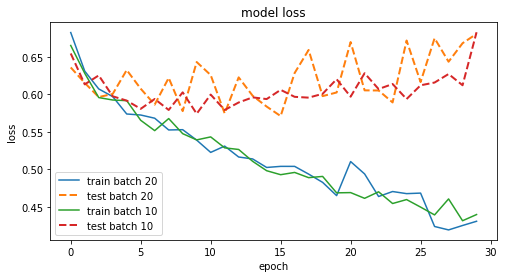

In [289]:
from IPython.core.pylabtools import figsize
figsize(8,4)
drow_history_list(history_list=[history_sgd_b20, history_sgd_b10], 
                  history_names=['batch 20', 'batch 10'],  metric=None)

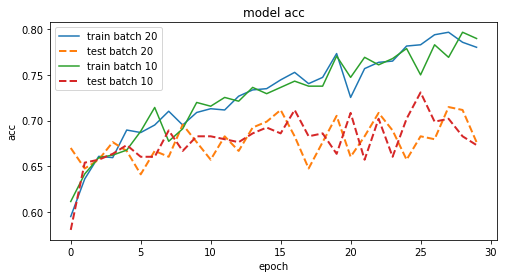

In [290]:
drow_history_list(history_list=[history_sgd_b20, history_sgd_b10], 
                  history_names=['batch 20', 'batch 10'],metric='acc')

In [282]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.682908557929
Test accuracy: 0.673076921549


## Predict

In [283]:
pred_test = model.predict(X_test)
y_pred_test = np.where(pred_test > 0.5, 1, 0).flatten()
print_stats(y_test,y_pred_test )

Accuracy: 0.67308, Cohen's Kappa Score: 0.34976
Confusion Matrix:
[[116  35]
 [ 67  94]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.77      0.69       151
           1       0.73      0.58      0.65       161

   micro avg       0.67      0.67      0.67       312
   macro avg       0.68      0.68      0.67       312
weighted avg       0.68      0.67      0.67       312



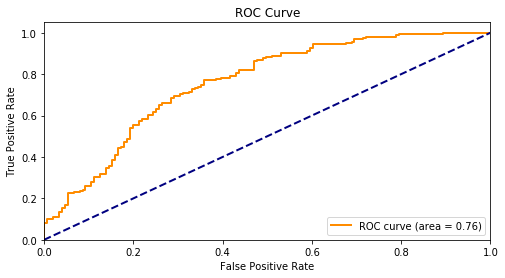

In [284]:
uplot.drow_roc_curve(y_test, model.predict(X_test))

Check best model

In [285]:
model_best = get_model(optimizer=optimizers.Adadelta())
model_best.load_weights('best_model_e50_b10_oSgd.h5')

pred_test = model_best.predict(X_test)
y_pred_test = np.where(pred_test > 0.5, 1, 0).flatten()
print_stats(y_test,y_pred_test )

Accuracy: 0.73077, Cohen's Kappa Score: 0.45876
Confusion Matrix:
[[ 99  52]
 [ 32 129]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.66      0.70       151
           1       0.71      0.80      0.75       161

   micro avg       0.73      0.73      0.73       312
   macro avg       0.73      0.73      0.73       312
weighted avg       0.73      0.73      0.73       312

